In [1]:
import gc  
import numpy as np  
import pandas as pd  
import xgboost as xgb  
from tqdm.notebook import tqdm  

BASE = '../input/godaddy-microbusiness-density-forecasting/'
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2) 
    pos_ind = (y_true!=0)|(y_pred!=0)
    
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    return 100 * np.mean(smap)
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    return 100 * smap
!ls ../input/godaddy-microbusiness-density-forecasting

census_starter.csv  sample_submission.csv  test.csv  train.csv


In [2]:
train = pd.read_csv(BASE+'train.csv')
test = pd.read_csv(BASE+'test.csv')
sub = pd.read_csv(BASE+'sample_submission.csv')
print(train.shape, test.shape, sub.shape)
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw.tail(25)

(122265, 7) (25080, 3) (25080, 2)


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i
147320,56045_2021-06-01,56045,Weston County,Wyoming,2021-06-01,1.652596,92.0,0,2021,6,22,3134,50
147321,56045_2021-07-01,56045,Weston County,Wyoming,2021-07-01,1.652596,92.0,0,2021,7,23,3134,50
147322,56045_2021-08-01,56045,Weston County,Wyoming,2021-08-01,1.670559,93.0,0,2021,8,24,3134,50
147323,56045_2021-09-01,56045,Weston County,Wyoming,2021-09-01,1.688522,94.0,0,2021,9,25,3134,50
147324,56045_2021-10-01,56045,Weston County,Wyoming,2021-10-01,1.670559,93.0,0,2021,10,26,3134,50
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50


<AxesSubplot:xlabel='dcount'>

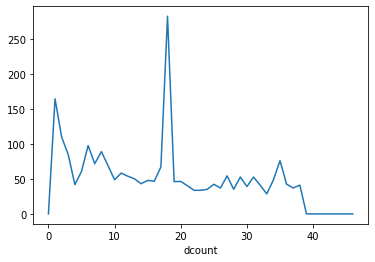

In [3]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()


In [4]:
raw.describe()

,cfips,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif
count,147345.00000,122265.000000,1.222650e+05,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000,147338.000000,147345.000000
mean,30376.03764,3.817671,6.442858e+03,0.170213,2021.042553,6.489362,23.000000,1567.000000,26.229665,3.806126,0.015942
std,15143.49818,4.991087,3.304001e+04,0.375821,1.202085,3.487816,13.564706,904.999572,14.253984,5.181853,0.175887
min,1001.00000,0.000000,0.000000e+00,0.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18177.00000,1.639344,1.450000e+02,0.000000,2020.000000,3.000000,11.000000,783.000000,14.000000,1.631321,0.000000
50%,29173.00000,2.586543,4.880000e+02,0.000000,2021.000000,6.000000,23.000000,1567.000000,25.000000,2.581933,0.005736
75%,45077.00000,4.519231,2.124000e+03,0.000000,2022.000000,10.000000,35.000000,2351.000000,40.000000,4.505917,0.015523
max,56045.00000,284.340030,1.167744e+06,1.000000,2023.000000,12.000000,46.000000,3134.000000,50.000000,284.340030,47.354986


In [5]:
outliers = []
cnt = 0 
for o in tqdm(raw.cfips.unique()):
    indices = (raw['cfips']==o)
    tmp = raw.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    for i in range(37, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    raw.loc[indices, 'microbusiness_density'] = var
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == "__main__":


(481, 732)

In [6]:
outliers

array([ 1013,  1035,  1037,  1045,  1057,  1059,  1085,  1111,  1125,
        1131,  1133,  2060,  2070,  2100,  2164,  2188,  2282,  5011,
        5029,  5031,  5049,  5061,  5065,  5077,  5079,  5081,  5091,
        5093,  5113,  5141,  6005,  6015,  8011,  8014,  8031,  8047,
        8055,  8057,  8069,  8079,  8081,  8105,  8121, 10003, 10005,
       12001, 12013, 12029, 12037, 12045, 12051, 12065, 12077, 12107,
       12131, 13007, 13019, 13025, 13033, 13037, 13061, 13087, 13101,
       13119, 13131, 13149, 13169, 13193, 13239, 13243, 13251, 13287,
       13291, 13301, 13307, 13317, 15005, 16009, 16021, 16025, 16033,
       16037, 16045, 16049, 16051, 16077, 16079, 17013, 17037, 17063,
       17065, 17075, 17105, 17109, 17127, 17147, 17175, 17191, 18017,
       18025, 18031, 18039, 18041, 18049, 18073, 18083, 18087, 18103,
       18143, 18145, 18153, 18171, 19001, 19003, 19005, 19033, 19037,
       19051, 19063, 19065, 19067, 19071, 19125, 19129, 19133, 19143,
       19165, 19175,

In [7]:
raw.describe()

,cfips,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif
count,147345.00000,1.222430e+05,1.222650e+05,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000,147345.000000,147338.000000,147345.000000
mean,30376.03764,inf,6.442858e+03,0.170213,2021.042553,6.489362,23.000000,1567.000000,26.229665,3.806126,0.015942
std,15143.49818,NaN,3.304001e+04,0.375821,1.202085,3.487816,13.564706,904.999572,14.253984,5.181853,0.175887
min,1001.00000,0.000000e+00,0.000000e+00,0.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18177.00000,1.659008e+00,1.450000e+02,0.000000,2020.000000,3.000000,11.000000,783.000000,14.000000,1.631321,0.000000
50%,29173.00000,2.609592e+00,4.880000e+02,0.000000,2021.000000,6.000000,23.000000,1567.000000,25.000000,2.581933,0.005736
75%,45077.00000,4.562146e+00,2.124000e+03,0.000000,2022.000000,10.000000,35.000000,2351.000000,40.000000,4.505917,0.015523
max,56045.00000,inf,1.167744e+06,1.000000,2023.000000,12.000000,46.000000,3134.000000,50.000000,284.340030,47.354986


<AxesSubplot:xlabel='dcount'>

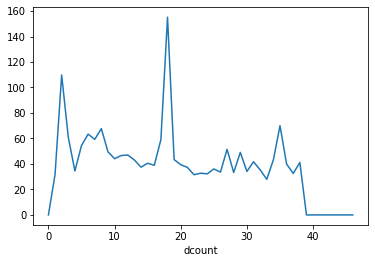

In [8]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

<AxesSubplot:xlabel='dcount'>

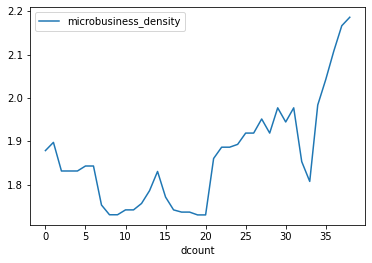

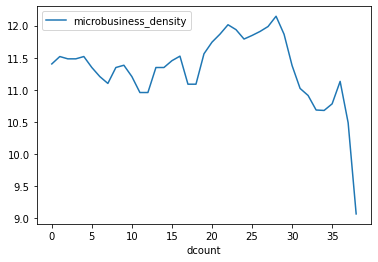

In [9]:
raw.loc[raw.cfips == 1013].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

In [10]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)
raw['target'] = raw['target']/raw['microbusiness_density'] - 1
raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0
raw.iloc[-20:,:20]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,state_i,mbd_lag_1,dif,target
147325,56045_2021-11-01,56045,Weston County,Wyoming,2021-11-01,1.760374,98.0,0,2021,11,27,3134,50,1.670559,0.053763,0.020408
147326,56045_2021-12-01,56045,Weston County,Wyoming,2021-12-01,1.796300,100.0,0,2021,12,28,3134,50,1.760374,0.020408,-0.025949
147327,56045_2022-01-01,56045,Weston County,Wyoming,2022-01-01,1.749688,98.0,0,2022,1,29,3134,50,1.796300,0.025949,0.000000
147328,56045_2022-02-01,56045,Weston County,Wyoming,2022-02-01,1.749688,98.0,0,2022,2,30,3134,50,1.749688,0.000000,0.010204
147329,56045_2022-03-01,56045,Weston County,Wyoming,2022-03-01,1.767542,99.0,0,2022,3,31,3134,50,1.749688,0.010204,0.000000
147330,56045_2022-04-01,56045,Weston County,Wyoming,2022-04-01,1.767542,99.0,0,2022,4,32,3134,50,1.767542,0.000000,0.020202
147331,56045_2022-05-01,56045,Weston County,Wyoming,2022-05-01,1.803249,101.0,0,2022,5,33,3134,50,1.767542,0.020202,0.000000
147332,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101.0,0,2022,6,34,3134,50,1.803249,0.000000,0.000000
147333,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101.0,0,2022,7,35,3134,50,1.803249,0.000000,-0.009901
147334,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100.0,0,2022,8,36,3134,50,1.803249,0.009901,0.000000


<AxesSubplot:>

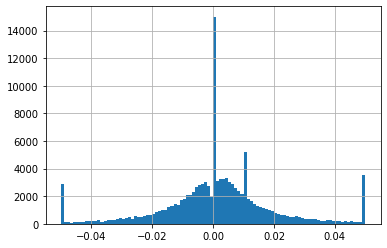

In [11]:
raw['target'].clip(-0.05, 0.05).hist(bins=100)

<AxesSubplot:>

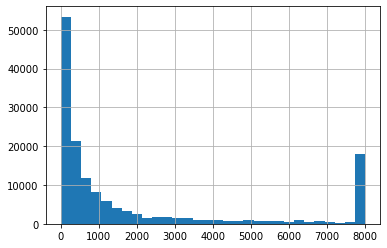

In [12]:
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')
dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')
raw['lasttarget'] = raw['cfips'].map(dt)
raw['lastactive'].clip(0, 8000).hist(bins=30)

In [13]:
 def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [14]:
raw, feats = build_features(raw, 'target', 'active', lags = 4)
features = ['state_i']
features += feats
print(features)
raw.loc[raw.dcount==38, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


In [15]:
raw_state=raw['state_i']
raw = pd.get_dummies(raw,columns=['state_i'],drop_first=True)
raw['state_i']=raw_state

In [16]:
features =['state_i_1', 'state_i_2',
       'state_i_3', 'state_i_4', 'state_i_5', 'state_i_6', 'state_i_7',
       'state_i_8', 'state_i_9', 'state_i_10', 'state_i_11', 'state_i_12',
       'state_i_13', 'state_i_14', 'state_i_15', 'state_i_16', 'state_i_17',
       'state_i_18', 'state_i_19', 'state_i_20', 'state_i_21', 'state_i_22',
       'state_i_23', 'state_i_24', 'state_i_25', 'state_i_26', 'state_i_27',
       'state_i_28', 'state_i_29', 'state_i_30', 'state_i_31', 'state_i_32',
       'state_i_33', 'state_i_34', 'state_i_35', 'state_i_36', 'state_i_37',
       'state_i_38', 'state_i_39', 'state_i_40', 'state_i_41', 'state_i_42',
       'state_i_43', 'state_i_44', 'state_i_45', 'state_i_46', 'state_i_47',
       'state_i_48', 'state_i_49', 'state_i_50', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']

In [17]:
raw.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'istest', 'year', 'month', 'dcount',
       'county_i', 'mbd_lag_1', 'dif', 'target', 'lastactive', 'lasttarget',
       'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3',
       'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1', 'state_i_1',
       'state_i_2', 'state_i_3', 'state_i_4', 'state_i_5', 'state_i_6',
       'state_i_7', 'state_i_8', 'state_i_9', 'state_i_10', 'state_i_11',
       'state_i_12', 'state_i_13', 'state_i_14', 'state_i_15', 'state_i_16',
       'state_i_17', 'state_i_18', 'state_i_19', 'state_i_20', 'state_i_21',
       'state_i_22', 'state_i_23', 'state_i_24', 'state_i_25', 'state_i_26',
       'state_i_27', 'state_i_28', 'state_i_29', 'state_i_30', 'state_i_31',
       'state_i_32', 'state_i_33', 'state_i_34', 'state_i_35', 'state_i_36',
       'state_i_37', 'state_i_38', 'state_i_39', 'state_i_40', 'state_i_41',
       'state_i_42', 's

In [18]:
raw.loc[raw.dcount==38, features].head(10)

,state_i_1,state_i_2,state_i_3,state_i_4,state_i_5,state_i_6,state_i_7,state_i_8,state_i_9,state_i_10,...,state_i_50,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0,0,0,0,0,0,0,0,0,...,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0,0,0,0,0,0,0,0,0,...,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0,0,0,0,0,0,0,0,0,...,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,0,0,0,0,0,0,0,0,0,...,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,0,0,0,0,0,0,0,0,0,...,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0,0,0,0,0,0,0,0,0,...,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0,0,0,0,0,0,0,0,0,...,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,0,0,0,0,0,0,0,0,0,...,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,0,0,0,0,0,0,0,0,0,...,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,0,0,0,0,0,0,0,0,0,...,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884


<AxesSubplot:>

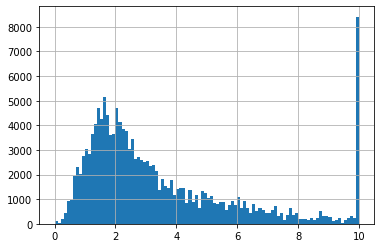

In [19]:
raw['lasttarget'].clip(0,10).hist(bins=100)

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
TS=37
ACT_THR = 1.8
ABS_THR = 1.00
train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.istest==0) & (raw.dcount == TS)

params = { 'max_depth':range(2,10,2)
         }
xgbr = xgb.XGBRegressor(objective='reg:pseudohubererror',
        #objective='reg:squaredlogerror',
        #booster='gblinear',
        tree_method="hist",
        n_estimators=5999,
        learning_rate=0.0075,
        max_leaves = 31,
        max_depth=6,
        subsample=0.50,
        colsample_bylevel=0.8999999999999999,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        gamma=0.0,
        eval_metric='mae',
        huber_slope=1.25,
        #feature_selector='greedy',
        early_stopping_rounds=70,
                        seed = 30
                       )
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_absolute_error', 
                   verbose=1)
clf.fit(raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

In [20]:
#features=['state_i','act_lag_1','act_lag_2','act_lag_4','act_lag_6','act_lag_11']
blacklist = [
    'North Dakota', 'Iowa', 'Kansas', 'Nebraska', 'South Dakota','New Mexico', 'Alaska', 'Vermont'
]
blacklistcfips = [ 
    13235,37157,48259,8027,21069,29013,54107,5097,37193,8017,6021,1019,1027,1029,1035,1039,1045,1049,1057,1067,1071,1077,1085,1091,1099,1101,1123,1131,1133,4001,4012,4013,4021,4023,5001,5003,5005,5017,5019,5027,5031,5035,5047,5063,5065,5071,5081,5083,5087,5091,5093,5107,5109,5115,5121,5137,5139,5141,5147,6003,6015,6027,6033,6053,6055,6057,6071,6093,6097,6103,6105,6115,8003,8007,8009,8019,8021,8023,8047,8051,8053,8055,8057,8059,8061,8065,8067,8069,8071,8073,8075,8085,8091,8093,8097,8099,8103,8105,8107,8109,8111,8115,8117,8121,9007,9009,9015,12009,12017,12019,12029,12047,12055,12065,12075,12093,12107,12127,13005,13007,13015,13017,13019,13027,13035,13047,13065,13081,13083,13099,13107,13109,13117,13119,13121,13123,13125,13127,13135,13143,13147,13161,13165,13171,13175,13181,13193,13201,13221,13225,13229,13231,13233,13245,13247,13249,13257,13279,13281,13287,13289,13293,13301,13319,15001,15005,15007,16001,16003,16005,16007,16013,16015,16017,16023,16025,16029,16031,16033,16035,16037,16043,16045,16049,16061,16063,16067,17001,17003,17007,17009,17013,17015,17023,17025,17031,17035,17045,17051,17059,17061,17063,17065,17067,17069,17075,17077,17081,17085,17087,17103,17105,17107,17109,17115,17117,17123,17127,17133,17137,17141,17143,17147,17153,17167,17169,17171,17177,17179,17181,17185,17187,17193,18001,18007,18009,18013,18015,18019,18021,18025,18035,18037,18039,18041,18053,18061,18075,18079,18083,18087,18099,18103,18111,18113,18115,18137,18139,18145,18153,18171,18179,21001,21003,21013,21017,21023,21029,21035,21037,21039,21045,21047,21055,21059,21065,21075,21077,21085,21091,21093,21097,21099,21101,21103,21115,21125,21137,21139,21141,21149,21155,21157,21161,21165,21179,21183,21191,21197,21199,21215,21217,21223,21227,21237,21239,22019,22021,22031,22039,22041,22047,22069,22085,22089,22101,22103,22109,22111,22115,22119,22121,23003,23009,23021,23027,23029,24011,24027,24029,24031,24035,24037,24039,24041,25011,25015,26003,26007,26011,26019,26021,26025,26027,26033,26037,26041,26043,26051,26053,26057,26059,26061,26065,26071,26077,26079,26083,26089,26097,26101,26103,26109,26111,26115,26117,26119,26127,26129,26131,26135,26141,26143,26155,26161,26165,27005,27011,27013,27015,27017,27021,27023,27025,27029,27047,27051,27055,27057,27065,27069,27073,27075,27077,27079,27087,27091,27095,27101,27103,27105,27107,27109,27113,27117,27119,27123,27125,27129,27131,27133,27135,27141,27147,27149,27155,27159,27167,27169,28017,28019,28023,28025,28035,28045,28049,28061,28063,28093,28097,28099,28125,28137,28139,28147,28159,29001,29015,29019,29031,29033,29041,29049,29051,29055,29057,29063,29065,29069,29075,29085,29089,29101,29103,29111,29121,29123,29125,29135,29137,29139,29143,29157,29159,29161,29167,29171,29173,29175,29177,29183,29195,29197,29199,29203,29205,29207,29209,29213,29215,29217,29223,29227,29229,30005,30009,30025,30027,30033,30035,30037,30039,30045,30049,30051,30053,30055,30057,30059,30069,30071,30073,30077,30079,30083,30085,30089,30091,30093,30101,30103,30105,30107,30109,32005,32009,32017,32023,32027,32029,32510,33005,33007,34021,34027,34033,34035,36011,36017,36023,36033,36043,36047,36049,36051,36057,36061,36067,36083,36091,36097,36103,36107,36113,36115,36121,36123,37005,37009,37011,37017,37023,37029,37031,37049,37061,37075,37095,37117,37123,37131,37137,37151,37187,37189,37197,39005,39009,39015,39017,39019,39023,39037,39039,39043,39049,39053,39057,39063,39067,39071,39077,39085,39087,39091,39097,39105,39107,39113,39117,39119,39125,39127,39129,39135,39137,39151,39153,39157,40003,40013,40015,40023,40025,40027,40035,40039,40043,40045,40053,40055,40057,40059,40065,40067,40073,40077,40079,40099,40105,40107,40111,40115,40123,40127,40129,40133,40141,40147,40151,40153,41001,41007,41013,41015,41017,41021,41025,41031,41033,41037,41051,41055,41063,41067,41069,42005,42007,42011,42013,42015,42019,42027,42029,42031,42035,42053,42057,42067,42071,42083,42085,42093,42097,42105,42111,42113,42115,42123,42125,42127,42129,44005,44007,44009,45001,45009,45021,45025,45031,45059,45067,45071,45073,45089,47001,47005,47013,47015,47019,47021,47023,47027,47035,47039,47041,47047,47055,47057,47059,47061,47069,47073,47075,47077,47083,47087,47099,47105,47121,47127,47131,47133,47135,47137,47147,47151,47153,47159,47161,47163,47169,47177,47183,47185,48001,48011,48017,48019,48045,48057,48059,48063,48065,48073,48077,48079,48081,48083,48087,48095,48101,48103,48107,48109,48115,48117,48119,48123,48125,48129,48149,48151,48153,48155,48159,48161,48165,48175,48189,48191,48195,48197,48211,48221,48229,48233,48235,48237,48239,48241,48243,48245,48255,48261,48263,48265,48267,48269,48275,48277,48283,48293,48299,48305,48311,48313,48319,48321,48323,48327,48333,48345,48347,48355,48369,48377,48379,48383,48387,48389,48401,48403,48413,48417,48431,48433,48437,48443,48447,48453,48455,48457,48461,48463,48465,48469,48471,48481,48483,48485,48487,48495,48499,49001,49009,49013,49019,49027,49031,49045,51005,51017,51025,51029,51031,51036,51037,51043,51057,51059,51065,51071,51073,51077,51079,51083,51091,51095,51097,51101,51111,51115,51119,51121,51127,51135,51147,51155,51159,51165,51167,51171,51173,51181,51183,51191,51197,51530,51590,51610,51620,51670,51678,51720,51735,51750,51770,51810,51820,53013,53019,53023,53031,53033,53037,53039,53041,53047,53065,53069,53071,53075,54013,54019,54025,54031,54033,54041,54049,54055,54057,54063,54067,54071,54077,54079,54085,54089,54103,55001,55003,55005,55007,55011,55017,55021,55025,55029,55037,55043,55047,55049,55051,55061,55065,55067,55075,55077,55091,55097,55101,55103,55109,55117,55123,55125,55127,56007,56009,56011,56015,56017,56019,56021,56027,56031,56037,56043,56045,
12061,  6095, 49025, 18073, 29029, 29097, 48419, 51830, 30067, 26095, 18159, 32001, 54065, 54027, 13043, 48177, 55069, 48137, 30087, 29007, 13055, 48295, 28157, 29037, 45061, 22053, 13199, 47171, 53001, 55041, 51195, 18127, 29151, 48307, 51009, 16047, 29133,  5145, 17175, 21027, 48357, 29179, 13023, 16077, 48371, 21057, 16039, 21143, 48435, 48317, 48475,  5129, 36041, 48075, 29017, 47175, 39167, 47109, 17189, 17173, 28009, 39027, 48133, 18129, 48217, 40081, 36021,  6005, 42099, 18051, 36055, 53051, 6109, 21073, 27019,  6051, 48055,  8083, 48503, 17021, 10003, 41061, 22001, 22011, 21205, 48223, 51103, 51047, 16069, 17033, 41011,  6035, 47145, 27083, 18165, 36055, 12001, 26159,  8125, 34017,
28141, 55119, 48405, 40029, 18125, 21135, 29073, 55115, 37149,55039, 26029, 12099, 13251, 48421, 39007, 41043, 22015, 37115,54099, 51137, 22049, 55131, 17159, 56001, 40005, 18017, 28091,47101, 27037, 29005, 13239, 21019, 55085, 48253, 51139, 40101,13283, 18049, 39163, 45049, 51113,
]
ACT_THR = 1.8
ABS_THR = 1.00
raw['ypred_last'] = np.nan
raw['ypred'] = np.nan
raw['k'] = 1.
VAL = []
BEST_ROUNDS = []
for TS in range(29, 38):
    print(TS)
    
    model = xgb.XGBRegressor(
        objective='reg:pseudohubererror',
        #objective='reg:squaredlogerror',
        #booster='gblinear',
        tree_method="gpu_hist",
        n_estimators=5999,
        learning_rate=0.0075,
        colsample_bylevel=0.8999999999999999,
        max_depth=6,
        #reg_alpha=1e-05,
        #gamma=0.0,
        max_leaves = 31,
        subsample=0.50,
        colsample_bytree=0.50,
        max_bin=4096,
        n_jobs=2,
        eval_metric='mae',
        huber_slope=1.25,
        #feature_selector='greedy',
        early_stopping_rounds=70,
        seed=20,
    )
            
    train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
    valid_indices = (raw.istest==0) & (raw.dcount == TS)
    model.fit(
        raw.loc[train_indices, features],
        raw.loc[train_indices, 'target'].clip(-0.0043, 0.0045),
        eval_set=[(raw.loc[valid_indices, features], raw.loc[valid_indices, 'target'])],
        verbose=500,
    )
    best_rounds = model.best_iteration
    BEST_ROUNDS.append(model.best_iteration)
    ypred = model.predict(raw.loc[valid_indices, features])
    raw.loc[valid_indices, 'k'] = ypred + 1
    raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

    # Validate
    lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
    dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']
    
    df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
    df['pred'] = df['cfips'].map(dt)
    df['lastval'] = df['cfips'].map(lastval)
    
    df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
    df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
    df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
    df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
    raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
    raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
    
    print(f'TS: {TS}')
    print('Last Value SMAPE:', smape(df['microbusiness_density'], df['lastval']) )
    print('XGB SMAPE:', smape(df['microbusiness_density'], df['pred']))
    print()


ind = (raw.dcount>=30)&(raw.dcount<=38)
print( 'XGB SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred'] ) )
print( 'Last Value SMAPE:', smape( raw.loc[ind, 'microbusiness_density'],  raw.loc[ind, 'ypred_last'] ) )
#1.1635393862707653
#1.1634771058979978

29
[0]	validation_0-mae:0.49384
[500]	validation_0-mae:0.01453
[892]	validation_0-mae:0.01090
TS: 29
Last Value SMAPE: 1.0868726017655663
XGB SMAPE: 1.0728711699899185

30
[0]	validation_0-mae:0.48780
[500]	validation_0-mae:0.01271
[648]	validation_0-mae:0.01206
TS: 30
Last Value SMAPE: 1.318087470449913
XGB SMAPE: 1.1491967528945983

31
[0]	validation_0-mae:0.49349
[500]	validation_0-mae:0.01490
[945]	validation_0-mae:0.01118
TS: 31
Last Value SMAPE: 1.1258309832479911
XGB SMAPE: 1.1062746699458708

32
[0]	validation_0-mae:0.50029
[500]	validation_0-mae:0.01736
[1000]	validation_0-mae:0.00927
[1500]	validation_0-mae:0.00911
[2000]	validation_0-mae:0.00910
[2008]	validation_0-mae:0.00910
TS: 32
Last Value SMAPE: 0.897969439640235
XGB SMAPE: 0.9069828174002332

33
[0]	validation_0-mae:0.48965
[500]	validation_0-mae:0.01467
[685]	validation_0-mae:0.01329
TS: 33
Last Value SMAPE: 1.3686285670946152
XGB SMAPE: 1.260762564838984

34
[0]	validation_0-mae:0.47785
[500]	validation_0-mae:0.0159

In [21]:
raw['error'] = vsmape(raw['microbusiness_density'], raw['ypred'])
raw['error_last'] = vsmape(raw['microbusiness_density'], raw['ypred_last'])
raw.loc[(raw.dcount==30), ['microbusiness_density', 'ypred', 'error', 'error_last'] ]

,microbusiness_density,ypred,error,error_last
30,3.334431,3.301437,0.994422,1.135557
77,7.823300,7.735812,1.124583,1.155810
124,1.206827,1.187774,1.591322,1.687769
171,1.236650,1.215920,1.690430,1.834867
218,1.777708,1.754288,1.326137,1.403959
...,...,...,...,...
147140,2.892446,2.926768,1.179620,1.179620
147187,25.438322,25.545546,0.420619,0.368550
147234,3.954258,3.758193,5.084364,5.183206
147281,3.027295,3.027295,0.000000,0.000000


In [22]:
dt = raw.loc[(raw.dcount>=30)&(raw.dcount<=38) ].groupby(['cfips','dcount'])['error', 'error_last'].last()
dt['miss'] = dt['error'] > dt['error_last']
dt = dt.groupby('cfips')['miss'].mean()
dt = dt.loc[dt>=0.50]
dt.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


(10,)

In [23]:
len(dt.index)

10

In [24]:
','.join([str(i) for i in dt.index])

'5029,6081,13115,13219,25007,28115,36101,48361,53077,54083'

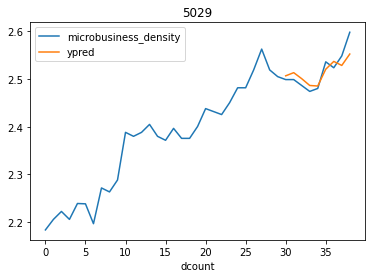

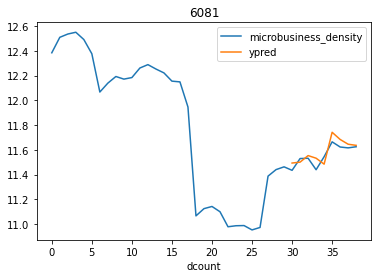

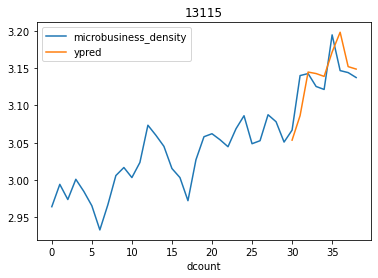

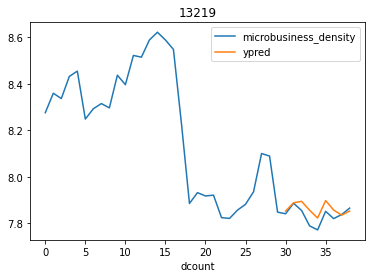

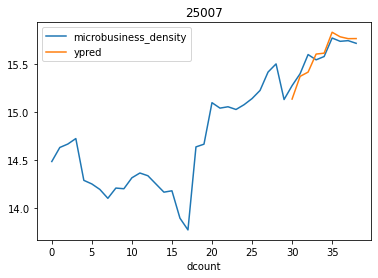

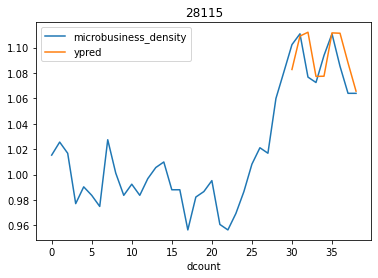

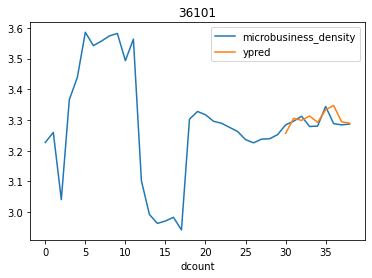

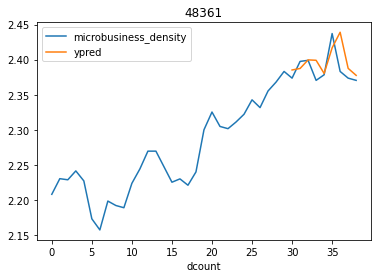

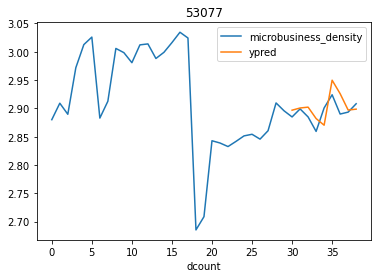

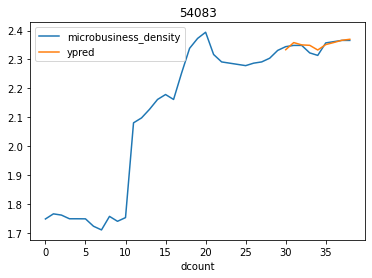

In [25]:
for d in dt.index[:20]:
    raw.loc[raw.cfips==d].plot(x='dcount', y=['microbusiness_density', 'ypred'], title=str(d))

In [26]:
raw.iloc[-40:, :16]

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_i,mbd_lag_1,dif,target,lastactive
147305,56045_2020-03-01,56045,Weston County,Wyoming,2020-03-01,1.537087,86.0,0,2020,3,7,3134,0.011765,0.011765,0.011628,100.0
147306,56045_2020-04-01,56045,Weston County,Wyoming,2020-04-01,1.554960,87.0,0,2020,4,8,3134,0.011628,0.011628,0.034483,100.0
147307,56045_2020-05-01,56045,Weston County,Wyoming,2020-05-01,1.608579,90.0,0,2020,5,9,3134,0.034483,0.034483,0.033333,100.0
147308,56045_2020-06-01,56045,Weston County,Wyoming,2020-06-01,1.662198,93.0,0,2020,6,10,3134,0.033333,0.033333,-0.064516,100.0
147309,56045_2020-07-01,56045,Weston County,Wyoming,2020-07-01,1.554960,87.0,0,2020,7,11,3134,-0.064516,0.064516,0.022989,100.0
147310,56045_2020-08-01,56045,Weston County,Wyoming,2020-08-01,1.590706,89.0,0,2020,8,12,3134,0.022989,0.022989,0.000000,100.0
147311,56045_2020-09-01,56045,Weston County,Wyoming,2020-09-01,1.590706,89.0,0,2020,9,13,3134,0.000000,0.000000,-0.022472,100.0
147312,56045_2020-10-01,56045,Weston County,Wyoming,2020-10-01,1.554960,87.0,0,2020,10,14,3134,-0.022472,0.022472,0.000000,100.0
147313,56045_2020-11-01,56045,Weston County,Wyoming,2020-11-01,1.554960,87.0,0,2020,11,15,3134,0.000000,0.000000,0.011494,100.0
147314,56045_2020-12-01,56045,Weston County,Wyoming,2020-12-01,1.572833,88.0,0,2020,12,16,3134,0.011494,0.011494,0.016450,100.0


In [27]:
raw.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,...,state_i_47,state_i_48,state_i_49,state_i_50,state_i,ypred_last,ypred,k,error,error_last
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,2019,8,...,0,0,0,0,0,NaN,NaN,1.0,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,...,0,0,0,0,0,NaN,NaN,1.0,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,...,0,0,0,0,0,NaN,NaN,1.0,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,...,0,0,0,0,0,NaN,NaN,1.0,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,...,0,0,0,0,0,NaN,NaN,1.0,NaN,NaN


In [28]:
np.mean( BEST_ROUNDS ), np.median( BEST_ROUNDS ), BEST_ROUNDS

(916.0, 797.0, [822, 578, 875, 1938, 615, 446, 1448, 725, 797])

In [29]:
best_rounds = int(np.median( BEST_ROUNDS )+1)
best_rounds

798

In [30]:
TS = 38
print(TS)

model0 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squaredlogerror',
    #booster='gblinear',
    tree_method="hist",
    n_estimators=best_rounds,
    colsample_bylevel=0.8999999999999999,
    max_depth=6,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    huber_slope=1.25,
    n_jobs=2,
    eval_metric='mae',
    seed=30,
)
model1 = xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    #objective='reg:squaredlogerror',
    #booster='gblinear',
    tree_method="hist",
    n_estimators=best_rounds,
    colsample_bylevel=0.8999999999999999,
    max_depth=6,
    learning_rate=0.0075,
    max_leaves = 31,
    subsample=0.60,
    colsample_bytree=0.50,
    max_bin=4096,
    huber_slope=1.25,
    n_jobs=2,
    eval_metric='mae',
    seed=30,
)

train_indices = (raw.istest==0) & (raw.dcount  < TS) & (raw.dcount >= 1) & (raw.lastactive>ACT_THR)  & (raw.lasttarget>ABS_THR) 
valid_indices = (raw.dcount == TS)
model0.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)
model1.fit(
    raw.loc[train_indices, features],
    raw.loc[train_indices, 'target'].clip(-0.0044, 0.0046),
)

ypred = (model0.predict(raw.loc[valid_indices, features]) + model1.predict(raw.loc[valid_indices, features]))/2
raw.loc[valid_indices, 'k'] = ypred + 1.
raw.loc[valid_indices,'k'] = raw.loc[valid_indices,'k'] * raw.loc[valid_indices,'microbusiness_density']

# Validate
lastval = raw.loc[raw.dcount==TS, ['cfips', 'microbusiness_density']].set_index('cfips').to_dict()['microbusiness_density']
dt = raw.loc[raw.dcount==TS, ['cfips', 'k']].set_index('cfips').to_dict()['k']

38


In [31]:
df = raw.loc[raw.dcount==(TS+1), ['cfips', 'microbusiness_density', 'state', 'lastactive', 'mbd_lag_1']].reset_index(drop=True)
df['pred'] = df['cfips'].map(dt)
df['lastval'] = df['cfips'].map(lastval)

df.loc[df['lastactive']<=ACT_THR, 'pred'] = df.loc[df['lastactive']<=ACT_THR, 'lastval']
df.loc[df['lastval']<=ABS_THR, 'pred'] = df.loc[df['lastval']<=ABS_THR, 'lastval']
df.loc[df['state'].isin(blacklist), 'pred'] = df.loc[df['state'].isin(blacklist), 'lastval']
df.loc[df['cfips'].isin(blacklistcfips), 'pred'] = df.loc[df['cfips'].isin(blacklistcfips), 'lastval']
raw.loc[raw.dcount==(TS+1), 'ypred'] = df['pred'].values
raw.loc[raw.dcount==(TS+1), 'ypred_last'] = df['lastval'].values
raw[['cfips','microbusiness_density','dcount','ypred','ypred_last','k']].tail(20)

,cfips,microbusiness_density,dcount,ypred,ypred_last,k
147325,56045,1.760374,27,NaN,NaN,1.000000
147326,56045,1.796300,28,NaN,NaN,1.000000
147327,56045,1.749688,29,NaN,NaN,1.751338
147328,56045,1.749688,30,1.749688,1.749688,1.760225
147329,56045,1.767542,31,1.749688,1.749688,1.768819
147330,56045,1.767542,32,1.767542,1.767542,1.767521
147331,56045,1.803249,33,1.767542,1.767542,1.811563
147332,56045,1.803249,34,1.803249,1.803249,1.832455
147333,56045,1.803249,35,1.803249,1.803249,1.803764
147334,56045,1.785395,36,1.803249,1.803249,1.789078


In [32]:
raw.loc[raw['cfips']==28055, 'microbusiness_density'] = 0
raw.loc[raw['cfips']==48269, 'microbusiness_density'] = 1.762115

dt = raw.loc[raw.dcount==39, ['cfips', 'ypred']].set_index('cfips').to_dict()['ypred']
test = raw.loc[raw.istest==1, ['row_id', 'cfips','microbusiness_density']].copy()
test['microbusiness_density'] = test['cfips'].map(dt)

test[['row_id','microbusiness_density']].to_csv('submission.csv', index=False)
test.head(40)

,row_id,cfips,microbusiness_density
39,1001_2022-11-01,1001,3.468151
40,1001_2022-12-01,1001,3.468151
41,1001_2023-01-01,1001,3.468151
42,1001_2023-02-01,1001,3.468151
43,1001_2023-03-01,1001,3.468151
44,1001_2023-04-01,1001,3.468151
45,1001_2023-05-01,1001,3.468151
46,1001_2023-06-01,1001,3.468151
86,1003_2022-11-01,1003,8.377823
87,1003_2022-12-01,1003,8.377823


In [33]:
import gc
gc.collect()

35143